In [2]:
"""
Load:
  x_a_init.txt
Save:
  x_b.txt
  x_a.txt
"""
import numpy as np
from scipy.integrate import ode
import lorenz96
import matplotlib.pyplot as plt
from settings import *
import matplotlib.pyplot as plt

In [3]:
def get_TLM(x): #x=[x1,x2,x3,...,xn]
    y = np.zeros((40,40))
    z = np.zeros((40,40))
    for n in range(40):
        z[n][n] = -1
        z[n][np.mod(n+1+1,40)-1] = x[np.mod(n-1+1,40)-1]
        z[n][np.mod(n-1+1,40)-1] = x[np.mod(n+1+1,40)-1]
        #print(np.mod(n-2+1,40)-1)
        z[n][np.mod(n-2+1,40)-1] = -1*x[np.mod(n+1+1,40)-1]
    return z

In [75]:
"""
Load:
  x_a_init.txt
Save:
  x_b.txt
  x_a.txt
"""
import numpy as np
from scipy.integrate import ode
import lorenz96
import matplotlib.pyplot as plt
from settings import *
nT = 800

#set random seed
np.random.seed(201910)

#load true value
x_t_save = np.genfromtxt('x_t.txt')



# load initial condition
x_a_init = np.genfromtxt('x_a_init.txt')
analysis_error = 25.e-2

np.random.seed(20191031)
# create observations

observation_error = 25.e-2
y_o_save = np.zeros([nT+1, N])
y_o_save = x_t_save + observation_error * np.random.randn(nT+1, N)


# initial x_b: no values at the initial time (assign NaN)
#x_b_save = np.full((1,N), np.nan, dtype='f8')
x_b_save = np.array([x_a_init])#test

##print(x_b_save)
# initial x_a: from x_a_ens_init

x_a_save = np.array([x_a_init])
#x_a_save = []
##print(x_a_save)


tt = 0#was 1

B = 0.0844 * np.identity(40)#backound error covariance 
#B = 0.25 * np.identity(40)#backound error covariance 

#B = np.genfromtxt('B_1224_raw.txt')
#B = B*0.6
R = 0.25 * np.identity(40) #observation error covariance

for i in range(40):
    for j in range(40):
        i = j
        if j+1 != 40:
            B[i][j+1] = 0.0064
        else:
            B[i][j+1-40] = 0.0064
            
        if j+1 != 40 and j+2 != 40:
            B[i][j+2] = -0.013
        else:
            B[i][j+2-40] = -0.013
            
        if j-1 != -1 :
            B[i][j-1] = +0.0064
        else:
            B[i][j-2+40] = +0.0064
            
        if j-2 != -1 and j-1 != -1:
            B[i][j-2] = -0.013
        else:
            B[i][j-2+40] = -0.013

B_temp_2 = B.copy()
B_a = np.reshape(B_f_mean,[40,40,1])
B_f = np.reshape(B_f_mean,[40,40,1])
#B_f = np.concatenate((B_f, np.reshape(B_f,[40,40,1])), axis = 2)
#B_f = np.concatenate((B_f, np.reshape(B_f,[40,40,2])), axis = 2)
#print(B_f.shape)
#print(np.dsplit(B_f,4)[1].shape)

while tt <= nT:
    ttf = tt + 1
    Ta = tt  * dT  # forecast start time(DA time)
    Tf = ttf * dT  # forecast end time
    #print('Cycle =', tt, ', Ta =', round(Ta, 10), ', Tf =', round(Tf, 10))
    #--------------
    # analysis step
    #--------------
    # background

    B = np.reshape(np.dsplit(B_f,ttf)[tt],[40,40])#.shape    
    
    x_b = x_b_save[tt].transpose()

    # observation
    y_o = y_o_save[tt].transpose()
    # innovation

    H = np.identity(40)
    y_b = np.dot(H, x_b)
    d = y_o - y_b

    # analysis scheme 
    K = np.dot(B, np.dot(H, np.linalg.inv(np.dot(H, np.dot(B,H))+R)))

    x_a = x_b + np.dot(K,d)

    if tt == 0: 
        x_a_save = np.reshape(x_a.transpose(),[1,40])
    else:
        x_a_save = np.vstack([x_a_save, x_a.transpose()])
        

    
    B_temp = B-np.dot(K,np.dot(H,B))
    B_a = np.concatenate((B_a, np.reshape(B_temp,[40,40,1])), axis = 2)
    #B_a = np.stack([B_a,B_temp], axis = 2)
    

    #--------------
    # forecast step
    #--------------

    solver = ode(lorenz96.f).set_integrator('dopri5')
    solver.set_initial_value(x_a_save[tt], Ta).set_f_params(F)
    solver.integrate(Tf)

    x_b_save = np.vstack([x_b_save, [solver.y]])
    TLM = get_TLM(np.reshape(x_a_save[0],[40,1]))

    
    B_f_temp = B_temp + (np.dot(get_TLM(np.reshape(x_a_save[tt],[40,1])),B_temp)+np.dot(get_TLM(np.reshape(x_a_save[tt],[40,1])),B_temp).transpose())*0.004
    B_f_temp = B_f_temp*1.20
    print("trace = ", np.trace(B_f_temp))
    B_f = np.concatenate((B_f, np.reshape(B_f_temp,[40,40,1])), axis = 2)
    
    
    tt += 1

# save background and analysis data
x_b_save = x_b_save[0:801][:]
np.savetxt('x_b_EKF.txt', x_b_save)
np.savetxt('x_a_EKF.txt', x_a_save)

trace =  1.9085188305449345
trace =  1.908988129032669
trace =  1.9097175581436585
trace =  1.9101308379127266
trace =  1.9100411574138239
trace =  1.9096009644427654
trace =  1.9090175080224634
trace =  1.9085336228432264
trace =  1.9081466583552547
trace =  1.9077679085586674
trace =  1.9073344417952032
trace =  1.9068844231090938
trace =  1.9064566537900325
trace =  1.9062435393926234
trace =  1.9063019015822547
trace =  1.9066716626431894
trace =  1.9072761686879147
trace =  1.907907419742938
trace =  1.9083470595329666
trace =  1.9083673459869763
trace =  1.9078659514251708
trace =  1.9068817512870102
trace =  1.9057896737058826
trace =  1.904977439276543
trace =  1.9046460047729132
trace =  1.9048949682786467
trace =  1.905619917297829
trace =  1.9067456587214278
trace =  1.908222744306637
trace =  1.9097390309846598
trace =  1.910968184233087
trace =  1.9116354047489086
trace =  1.9115925693005287
trace =  1.9107100526715994
trace =  1.9092334191771243
trace =  1.907383768346909

trace =  1.9080270337722798
trace =  1.9087207983078687
trace =  1.9089138915602146
trace =  1.9082264547816445
trace =  1.9065722092242947
trace =  1.9044075729907481
trace =  1.902286723947722
trace =  1.9007036579706917
trace =  1.8999156198862899
trace =  1.899749133765789
trace =  1.9000772012655895
trace =  1.9010349112844795
trace =  1.9025427216035944
trace =  1.904360602455873
trace =  1.9061610369322497
trace =  1.9074809900721614
trace =  1.90822361211535
trace =  1.9083175400438592
trace =  1.9078409161697958
trace =  1.906514319423333
trace =  1.9042961055576206
trace =  1.9014463018143735
trace =  1.8986948719998915
trace =  1.8965605434041057
trace =  1.8952944880910645
trace =  1.8949228383084216
trace =  1.895509729658935
trace =  1.8969253938697375
trace =  1.8988384071676756
trace =  1.9009391864033842
trace =  1.9029282013007185
trace =  1.9045934396034978
trace =  1.9057452235147165
trace =  1.9064393944216138
trace =  1.906472983053562
trace =  1.9057204868707354


trace =  1.8966602991327877
trace =  1.8979106902938443
trace =  1.90001851598243
trace =  1.9024681424921008
trace =  1.9046607888049576
trace =  1.9060552075105468
trace =  1.9064320814226123
trace =  1.9058919237030296
trace =  1.9046724211068427
trace =  1.903248206451973
trace =  1.901973307841981
trace =  1.9011144355318557
trace =  1.9006292819185169
trace =  1.900462821903861
trace =  1.9004996147054625
trace =  1.900593552139144
trace =  1.9006197078946219
trace =  1.9003114982816691
trace =  1.8993261100197536
trace =  1.897531489655052
trace =  1.8954461433509762
trace =  1.8937988476860343
trace =  1.8932363444586127
trace =  1.8937955536937316
trace =  1.8951818925333144
trace =  1.8969923838647962
trace =  1.898755901370185
trace =  1.900046153156814
trace =  1.9006299497115648
trace =  1.900396893688384
trace =  1.8994026327482887
trace =  1.8979778147403494
trace =  1.8966385686104927
trace =  1.8960350167868634
trace =  1.8966002343350836
trace =  1.8982325968064058
tr

In [76]:
#Do simple statistic
analysis_error = x_a_save-x_t_save
bias_t = []
rmse_t = []
for i in range(nT):
    
    bias_i = analysis_error[i][:].mean()
    rmse_i = np.std(analysis_error[i][:])
    bias_t = np.append(bias_t, bias_i)
    rmse_t = np.append(rmse_t, rmse_i)
rmse = rmse_t[30:800].mean()
bias = bias_t[30:800].mean()
print(rmse)

0.09786752106980083


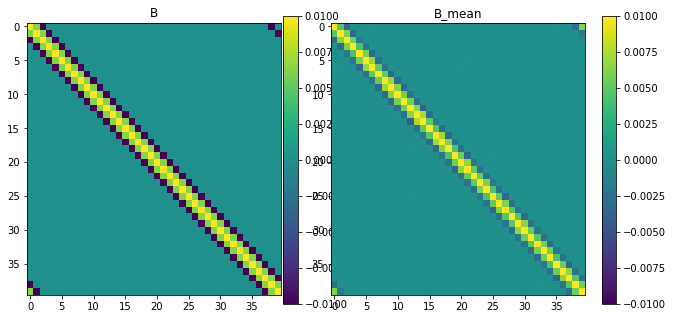

In [77]:
#print(B_f.shape)
#print(np.mean(B_f, axis = 2).shape)
#B_f_mean = np.mean(B_f, axis = 2)


fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(B_temp_2,vmin=-0.01,vmax=0.01)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.1, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('B_mean')
plt.imshow(B_f_mean,vmin=-0.01,vmax=0.01)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [78]:
print(B.size)
print(B.shape)
B_2 = np.concatenate([np.reshape(B,[40,40,1]),np.reshape(B,[40,40,1])], axis = 2)
print(B_2.shape)
B_3 = np.concatenate((B_2,np.reshape(B,[40,40,1])), axis = 2)
#B = np.vstack([B, B])
print(B_3.shape)
#print(B)

1600
(40, 40)
(40, 40, 2)
(40, 40, 3)


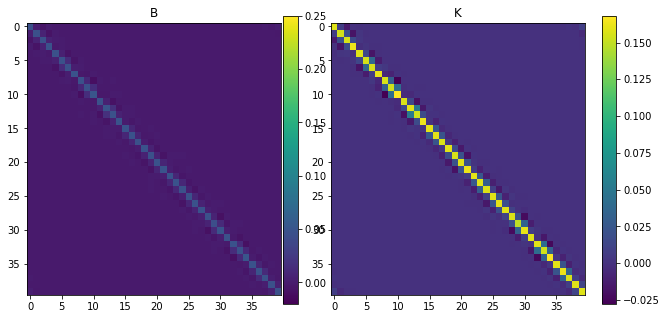

In [79]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(B,vmin=-0.02,vmax=0.25)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.1, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('K')
plt.imshow(K)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [80]:
#for i in range(10):
#    plt.plot(x_a_save[:][i])
#    #print(x_a_save[:][200])
#    plt.show()

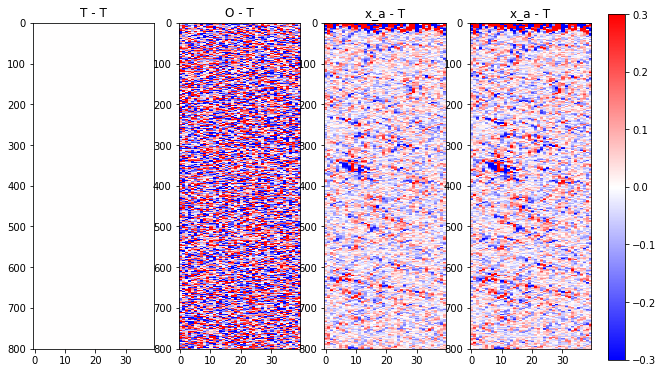

In [82]:
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(141)
ax.set_title('T - T')
plt.imshow(x_t_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax.set_aspect('auto')

ax2 = fig.add_subplot(142)
ax2.set_title('O - T')
plt.imshow(y_o_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax2.set_aspect('auto')


ax3 = fig.add_subplot(143)
ax3.set_title('x_a - T')
plt.imshow(x_a_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax3.set_aspect('auto')


ax4 = fig.add_subplot(144)
ax4.set_title('x_a - T')
plt.imshow(x_b_save[0:801][:]-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax4.set_aspect('auto')


cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

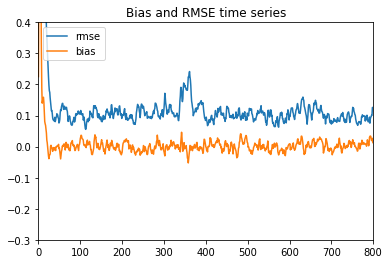

rmse= 0.10626723336146962
bias= 0.0008295269289822261


In [83]:
analysis_error = x_b_save-x_t_save
bias_t = []
rmse_t = []
for i in range(nT):
    
    bias_i = analysis_error[i][:].mean()
    rmse_i = np.std(analysis_error[i][:])
    bias_t = np.append(bias_t, bias_i)
    rmse_t = np.append(rmse_t, rmse_i)


plt.plot(rmse_t, label ="rmse" )
plt.plot(bias_t, label ="bias")
plt.ylim(-0.3,0.4)
plt.xlim(0,800)
plt.legend(loc="upper left")
plt.title("Bias and RMSE time series")
plt.show()
rmse = rmse_t[30:800].mean()
bias = bias_t[30:800].mean()
print("rmse=",rmse)
print("bias=",bias)
np.savetxt('EKF_bias.txt',bias_t)
np.savetxt('EKF_rmse.txt',rmse_t)